## Import python packages

In [2]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from dask.distributed import Client
import pandas as pd
import datetime

In [7]:
client = Client()   # create a local dask cluster on the local machine.
client
%matplotlib inline

## Create weights

In [8]:
def computeWeightedMean(ds):
    # Compute weights based on the xarray you pass
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    # Compute weighted mean
    air_weighted = ds.weighted(weights)
    weighted_mean = air_weighted.mean(("lon", "lat"))
    return weighted_mean

## Open CMIP6 online catalog & download desired data

In [9]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
waccm = col.search(source_id=['CESM2-WACCM'], experiment_id=['historical'], table_id=['Amon'], variable_id=['o3'], member_id=['r1i1p1f1'])
cam = col.search(source_id=['CESM2'], experiment_id=['historical'], table_id=['Amon'], variable_id=['o3'], member_id=['r1i1p1f1'])
cam.df
waccm.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2-WACCM,historical,r1i1p1f1,Amon,o3,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190415


In [5]:
col = col.search(source_id=['CESM2-WACCM'], experiment_id=['historical'], table_id=['Amon'], member_id=['r1i1p1f1'])

import pprint 
uni_dict = col.unique(['variable_id'])
pprint.pprint(uni_dict, compact=True)
#areacella

{'variable_id': {'count': 51,
                 'values': ['cl', 'rtmt', 'rldscs', 'rlutcs', 'ci', 'clt', 'pr',
                            'rsuscs', 'ch4', 'va', 'rsutcs', 'co2mass', 'huss',
                            'sbl', 'hurs', 'ta', 'o3', 'tauu', 'n2oglobal',
                            'cfc11global', 'rsut', 'cfc12global', 'co2', 'hus',
                            'hfss', 'hur', 'rsdscs', 'sfcWind', 'n2o', 'tas',
                            'ua', 'clw', 'cli', 'prw', 'tauv', 'ps', 'clivi',
                            'rlut', 'psl', 'clwvi', 'zg', 'rsds', 'hfls',
                            'rlds', 'rsus', 'rsdt', 'wap', 'evspsbl', 'ts',
                            'rlus', 'prc']}}


## Create dictionary from the list of datasets you want

In [10]:
ds_dict_waccm = waccm.to_dataset_dict(zarr_kwargs={'use_cftime':True})
ds_dict_cam = cam.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [11]:
print(list(ds_dict_waccm.keys()))
print(list(ds_dict_cam.keys()))
ds_waccm = ds_dict_waccm['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn']
ds_cam = ds_dict_cam['CMIP.NCAR.CESM2.historical.Amon.gn']

['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn']
['CMIP.NCAR.CESM2.historical.Amon.gn']


## Compute the mean values

In [8]:
weighted_mean_cam = computeWeightedMean(ds_cam.o3.where(ds_cam.o3['lat']>60.)).squeeze().sum('plev').compute()
print(weighted_mean_cam.isel(time=0).values)

3.4534909354973285e-05


In [9]:
weighted_mean_waccm = computeWeightedMean(ds_waccm.o3.where(ds_waccm.o3['lat']>60.)).squeeze().sum('plev').compute()
print(weighted_mean_waccm.isel(time=0).values)

3.322192262170995e-05


In [10]:
weighted_mean_cam_south = computeWeightedMean(ds_cam.o3.where(ds_cam.o3['lat']<-60.)).squeeze().sum('plev').compute()
print(weighted_mean_cam_south.isel(time=0).values)

weighted_mean_waccm_south = computeWeightedMean(ds_waccm.o3.where(ds_waccm.o3['lat']<-60.)).squeeze().sum('plev').compute()
print(weighted_mean_waccm_south.isel(time=0).values)

3.050665826122561e-05
2.7749250561399863e-05


## Plot WACCM and CAM in the northern and southern hemisphere for comparison

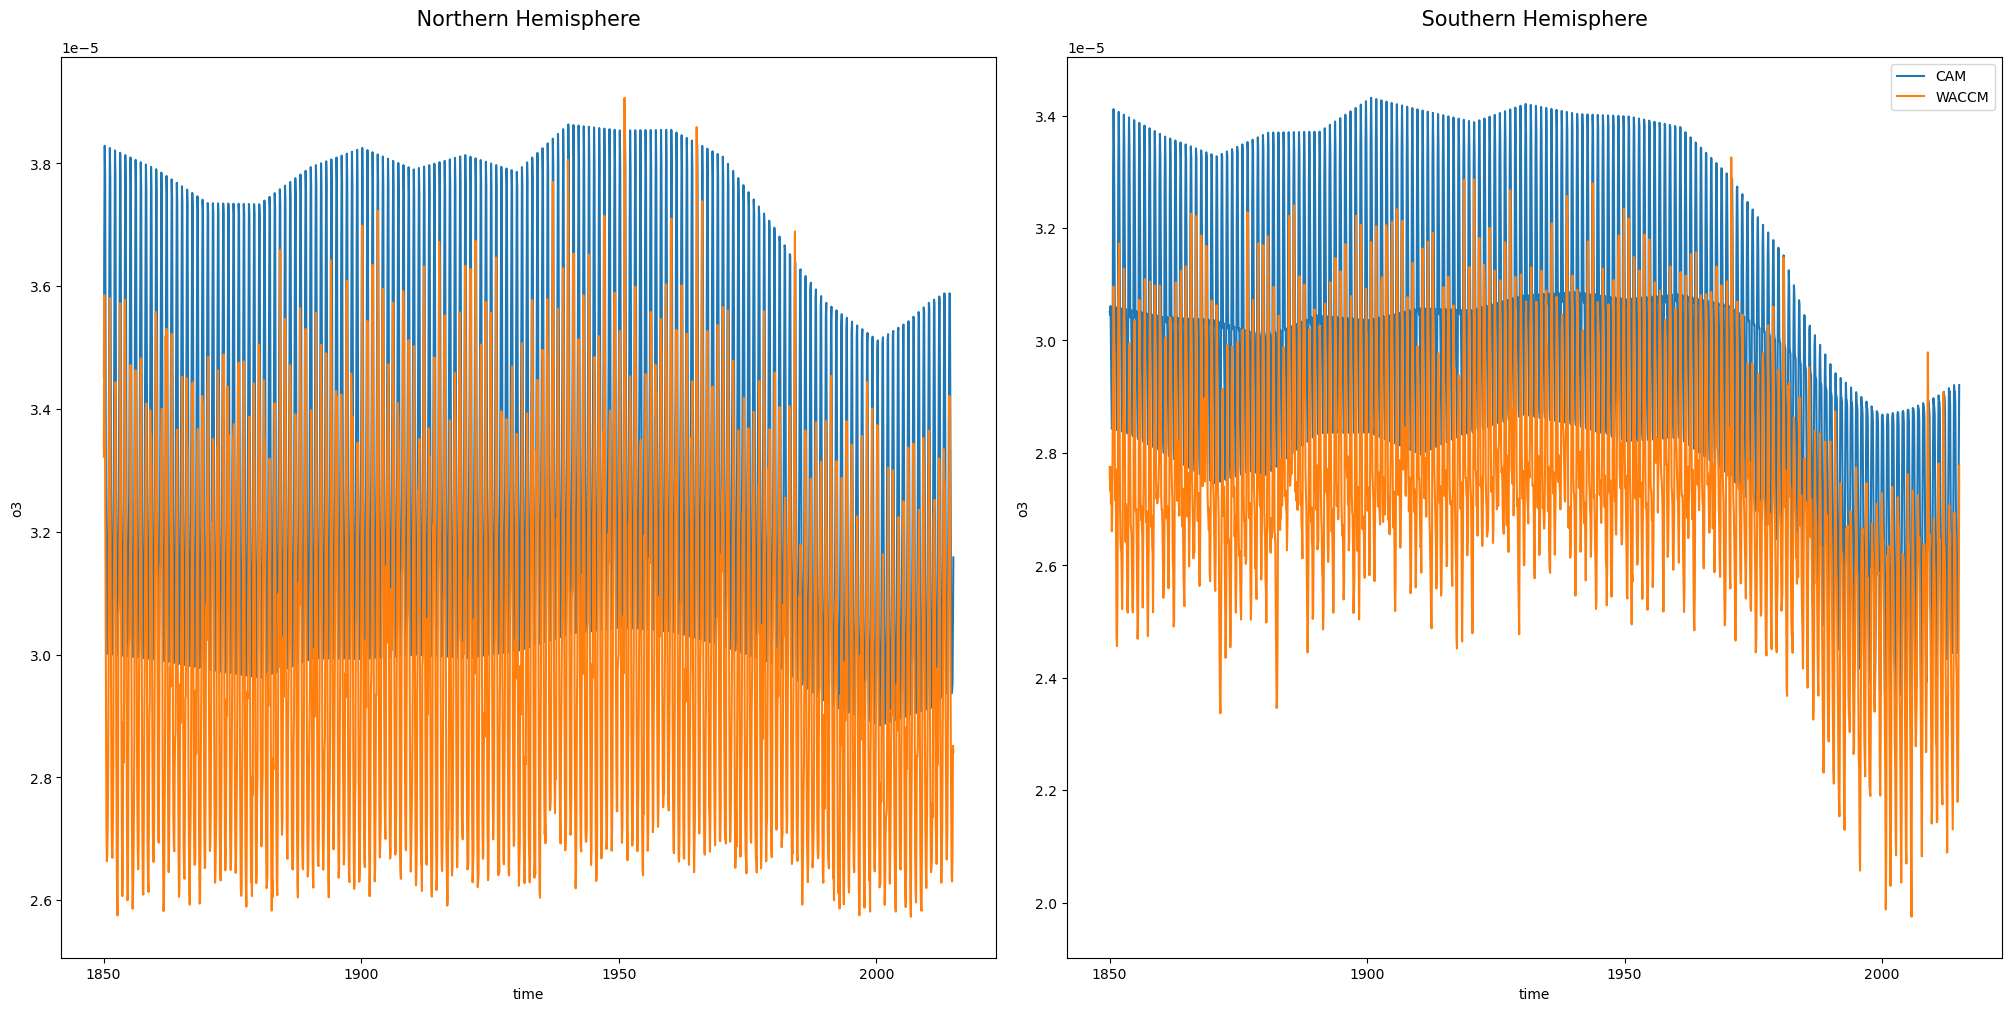

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20,10))

weighted_mean_cam.plot(label="CAM", ax=ax1)
weighted_mean_waccm.plot(label="WACCM", ax=ax1)

weighted_mean_cam_south.plot(label="CAM", ax=ax2)
weighted_mean_waccm_south.plot(label="WACCM", ax=ax2)

ax1.set_title(" Northern Hemisphere \n" , fontsize=15)
ax2.set_title(" Southern Hemisphere \n" , fontsize=15)
plt.legend()

NameError: name 'weighted_mean_cam' is not defined

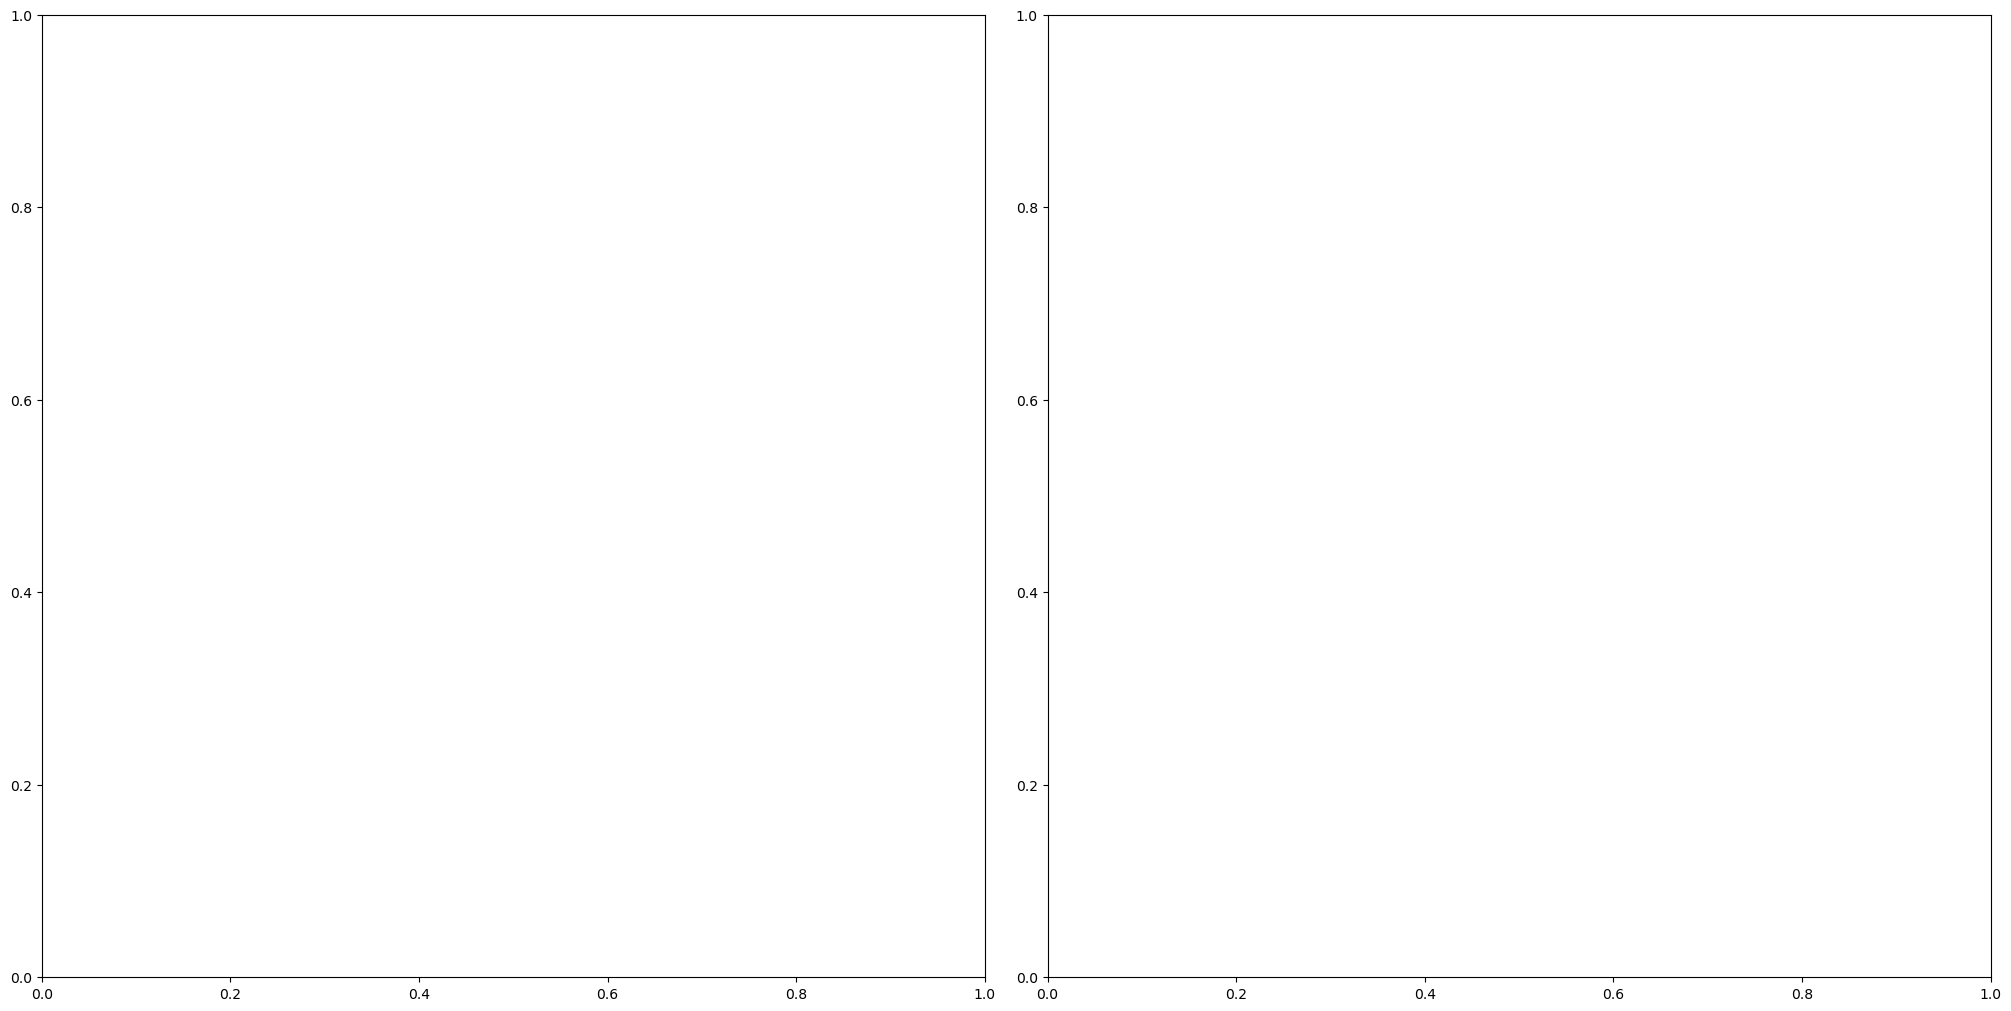

In [12]:
start = cftime.DatetimeNoLeap(1985,1,15)
end = cftime.DatetimeNoLeap(1996,1,15)

fig, (axs1, axs2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20,10))
#fig, ax = plt.figure(1, figsize=[20,10])
weighted_mean_cam.sel(time=slice(start,end)).plot(label="CAM", ax=axs1)
weighted_mean_waccm.sel(time=slice(start,end)).plot(label="WACCM", ax=axs1)

weighted_mean_cam_south.sel(time=slice(start,end)).plot(label="CAM", ax=axs2)
weighted_mean_waccm_south.sel(time=slice(start,end)).plot(label="WACCM", ax=axs2)

fig.suptitle('Ozone concentration\n', fontsize=20)

axs1.set_title(" Northern Hemisphere \n" , fontsize=15)
axs2.set_title(" Southern Hemisphere \n" , fontsize=15)
plt.legend()



## Calculate the anomaly 

In [ ]:
# no.1
# mean of every month for 30 years = climatology
# calculate anomaly = orig - climatology
# this gets rid of the the flux

#no.2
# calc mean of 5 years before the eruption 
# calc anomaly = mean(orig) - mean = mean(5 year prior) - mean(5 year prior & 5 year after)

In [49]:
start_prior_eruption = cftime.DatetimeNoLeap(1986,1,15)
end_prior_eruption = cftime.DatetimeNoLeap(1991,1,15)

end_during_eruption = cftime.DatetimeNoLeap(1997,1,15)

prior_erup = ds_waccm.o3.sel(time=slice(start_prior_eruption,end_prior_eruption)).squeeze().mean('time').sum('plev')
during_erup = ds_waccm.o3.sel(time=slice(start_prior_eruption,end_during_eruption)).sum('plev').squeeze()

In [48]:
ds_waccm.time

<xarray.DataArray 'time' (time: 1980)>
array([cftime.DatetimeNoLeap(1850, 1, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 14, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 15, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2014, 10, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 15, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
    title:          time
    type:           double

In [55]:
ds_w_pri = ds_waccm['o3'].sel(time=slice(start_prior_eruption,end_prior_eruption)).squeeze().groupby('time.year').mean('time').mean('year')

In [51]:
ds_w_dur = ds_waccm['o3'].sel(time=slice(start_prior_eruption,end_during_eruption)).squeeze().groupby('time.year').mean('time')

In [57]:
ds_w_anom = ds_w_dur - ds_w_pri

In [56]:
ds_w_pri


<xarray.DataArray 'o3' (plev: 19, lat: 192, lon: 288)>
dask.array<mean_agg-aggregate, shape=(19, 192, 288), dtype=float32, chunksize=(19, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
    member_id  <U8 'r1i1p1f1'

In [58]:
w_m_w_n_anomaly = computeWeightedMean(ds_w_anom.where(ds_w_anom['lat']>60.)).sum('plev').compute()
w_m_w_south_anomaly = computeWeightedMean(ds_w_anom.where(ds_w_anom['lat']<-60.)).sum('plev').compute()

In [59]:
w_m_w_n_anomaly

<xarray.DataArray 'o3' (year: 11)>
array([-9.41589701e-08, -2.64510726e-07,  2.23814831e-07, -1.12454268e-07,
        2.47393621e-07,  1.77388051e-07, -6.51167828e-07, -7.91228954e-07,
       -5.21109485e-07,  2.16819629e-07, -5.13432171e-07])
Coordinates:
    member_id  <U8 'r1i1p1f1'
  * year       (year) int64 1986 1987 1988 1989 1990 ... 1993 1994 1995 1996

In [41]:
print(ds_waccm_anomaly.isel(time=0).mean().values)
print(ds_waccm.o3.sel(time=start_prior_eruption, method='nearest').mean().values)

6.9009964e-08
1.6894645e-06


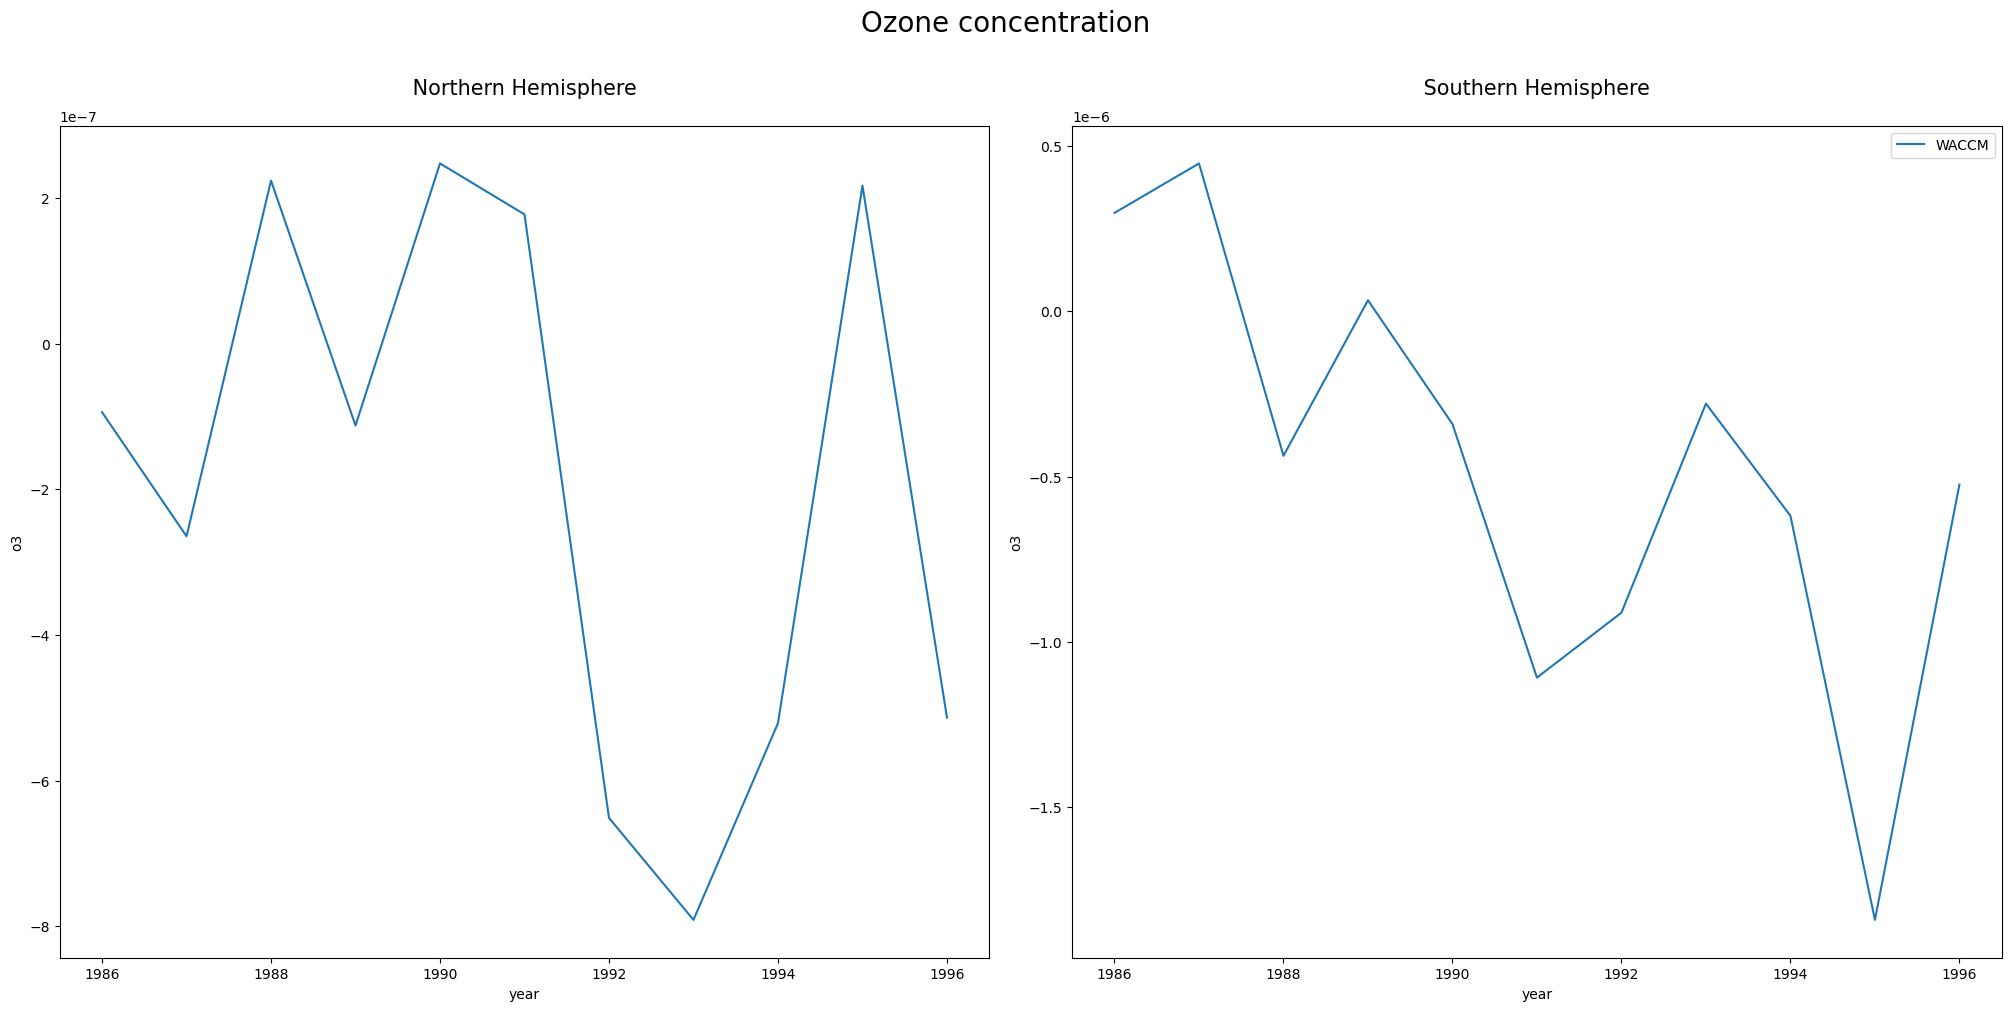

In [60]:
fig, (axs1, axs2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20,10))

#w_m_w_n_anomaly.sel(time=slice(start,end)).plot(label="CAM", ax=axs1)
w_m_w_n_anomaly.plot(label="WACCM", ax=axs1)
#weighted_mean_waccm.sel(time=slice(start,end)).plot(label="WACCM-org", ax=axs1)

#w_m_w_south_anomaly.sel(time=slice(start,end)).plot(label="CAM", ax=axs2)
w_m_w_south_anomaly.plot(label="WACCM", ax=axs2)
#weighted_mean_waccm_south.sel(time=slice(start,end)).plot(label="WACCM-org", ax=axs2)

fig.suptitle('Ozone concentration\n', fontsize=20)

axs1.set_title(" Northern Hemisphere \n" , fontsize=15)
axs2.set_title(" Southern Hemisphere \n" , fontsize=15)
plt.legend()

In [6]:
client.close()